# **Sesotho Dataset**

# 1. Setup and Imports

In [ ]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

nltk.download('punkt')
nltk.download('punkt_tab')

print("Setup Complete. All NLTK resources are ready.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Setup Complete. All NLTK resources are ready.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# 2.Load and Parse the Sesotho Dataset

In [ ]:
filename = 'sesotho_uncleaned_data.txt'
sentences = []
labels = []

try:
    with open(filename, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    for i in range(0, len(lines), 2):
        if i + 1 < len(lines):
            sentence = lines[i].strip()
            label_numeric = lines[i+1].strip()

            if sentence and label_numeric:
                sentences.append(sentence)
                labels.append(label_numeric)

    df_sesotho = pd.DataFrame({
        'text': sentences,
        'label_numeric': labels
    })

    label_map = {'-1': 'negative', '0': 'neutral', '1': 'positive'}
    df_sesotho['label'] = df_sesotho['label_numeric'].map(label_map)

    df_sesotho.dropna(subset=['label'], inplace=True)

    print("Data loaded and parsed successfully.")
    print(f"Total entries found: {len(df_sesotho)}")
    print("\nFirst 5 rows of the parsed data:")
    print(df_sesotho.head())

except FileNotFoundError:
    print(f"Error: The file '{filename}' was not found. Please upload it to your Colab session.")

Data loaded and parsed successfully.
Total entries found: 2208

First 5 rows of the parsed data:
                                                text label_numeric     label
0  BASUOE BA QOSUOE KA PELAELO EA HO BOLAEA MOSHE...            -1  negative
1                     TSEBA MARENA A SEHLOOHO A NAHA             0   neutral
2       LINTLHA-KHOLO MABAPI LE NTLO E OETSENG BATHO            -1  negative
3  MOTHO O KHAOTSOE BOTONA LE MENOANA A NTSE A PHELA            -1  negative
4  LITABA TSE BOHLOKO HO MAQHEKU LE MAQHEKOANA NA...            -1  negative


# 3. Clean and Prepare the Text

In [ ]:
def clean_text(text):
    """
    Cleans a text string by lowercasing, removing links, mentions,
    and non-alphabetic characters.
    """
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_sesotho['cleaned_text'] = df_sesotho['text'].apply(clean_text)
df_sesotho['tokens'] = df_sesotho['cleaned_text'].apply(word_tokenize)

print("DataFrame after Cleaning and Tokenization:")
print(df_sesotho[['text', 'cleaned_text', 'tokens', 'label']].head())

DataFrame after Cleaning and Tokenization:
                                                text  \
0  BASUOE BA QOSUOE KA PELAELO EA HO BOLAEA MOSHE...   
1                     TSEBA MARENA A SEHLOOHO A NAHA   
2       LINTLHA-KHOLO MABAPI LE NTLO E OETSENG BATHO   
3  MOTHO O KHAOTSOE BOTONA LE MENOANA A NTSE A PHELA   
4  LITABA TSE BOHLOKO HO MAQHEKU LE MAQHEKOANA NA...   

                                        cleaned_text  \
0  basuoe ba qosuoe ka pelaelo ea ho bolaea moshe...   
1                     tseba marena a sehlooho a naha   
2        lintlhakholo mabapi le ntlo e oetseng batho   
3  motho o khaotsoe botona le menoana a ntse a phela   
4  litaba tse bohloko ho maqheku le maqhekoana na...   

                                              tokens     label  
0  [basuoe, ba, qosuoe, ka, pelaelo, ea, ho, bola...  negative  
1              [tseba, marena, a, sehlooho, a, naha]   neutral  
2  [lintlhakholo, mabapi, le, ntlo, e, oetseng, b...  negative  
3  [motho, o, khaotsoe,

# 4. Visualize the Sesotho Data

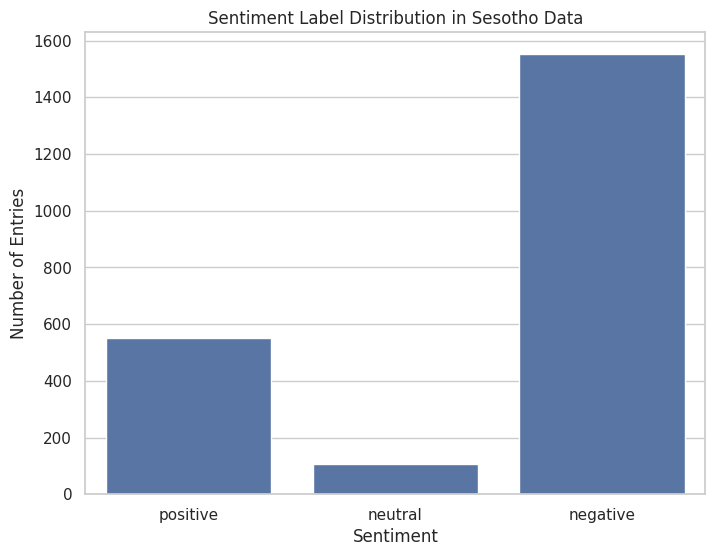

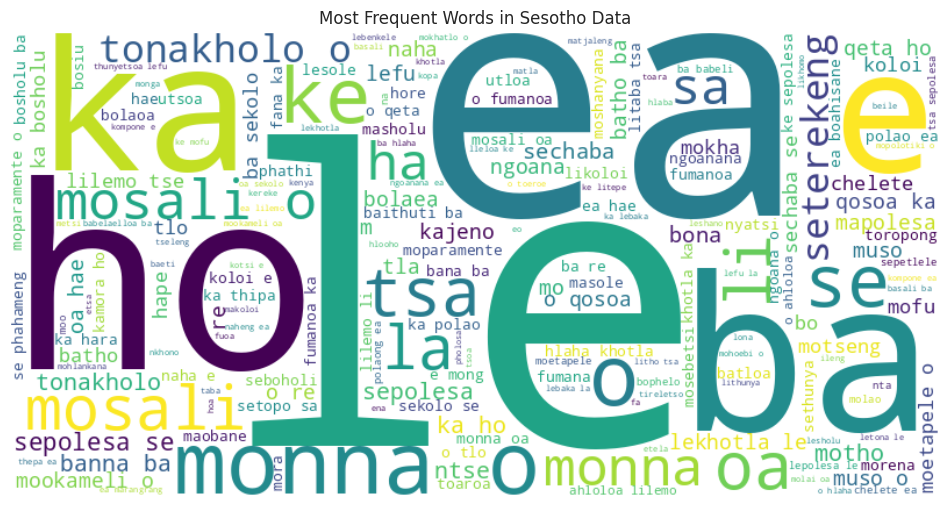

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df_sesotho, order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Label Distribution in Sesotho Data')
plt.xlabel('Sentiment')
plt.ylabel('Number of Entries')
plt.show()

all_words = ' '.join(df_sesotho['cleaned_text'].dropna())
if all_words:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Frequent Words in Sesotho Data')
    plt.show()
else:
    print("Not enough words to generate a word cloud after cleaning.")

# 5. Handle Class Imbalance with SMOTE(Synthetic Minority Over-sampling Technique)


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df_sesotho['cleaned_text'])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_sesotho['label'])

print("Original class distribution:", Counter(y))
print("Labels mapping:", {i: label for i, label in enumerate(label_encoder.classes_)})

min_class_size = min(Counter(y).values())
k_neighbors_for_smote = min(5, min_class_size - 1) if min_class_size > 1 else 1

if k_neighbors_for_smote < 1:
     print("Cannot apply SMOTE because the smallest class has only 1 sample.")
     X_resampled, y_resampled = X, y
else:
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors_for_smote)
    X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nResampled class distribution:", Counter(y_resampled))

Original class distribution: Counter({np.int64(0): 1552, np.int64(2): 550, np.int64(1): 106})
Labels mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}

Resampled class distribution: Counter({np.int64(0): 1552, np.int64(1): 1552, np.int64(2): 1552})


# 6.Get Data Ready for Training (Train-Test Split)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)

print("Shape of the training features:", X_train.shape)
print("Shape of the testing features:", X_test.shape)
print("Shape of the training labels:", y_train.shape)
print("Shape of the testing labels:", y_test.shape)

print("\nData is now cleaned, balanced, and split. It is ready for model training.")

Shape of the training features: (3724, 2974)
Shape of the testing features: (932, 2974)
Shape of the training labels: (3724,)
Shape of the testing labels: (932,)

Data is now cleaned, balanced, and split. It is ready for model training.


# Downloading data

In [ ]:
# Save the cleaned Sesotho dataset
df_sesotho.to_csv('cleaned_sesotho_data.csv', index=False)
print("Cleaned dataset saved as 'cleaned_sesotho_data.csv'")

# OPTIONAL: Try to trigger download if running in Google Colab
try:
    from google.colab import files
    files.download('cleaned_sesotho_data.csv')
    print("File download triggered in Google Colab")
except ImportError:
    print("Not running in Google Colab. File saved locally.")


Cleaned dataset saved as 'cleaned_sesotho_data.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File download triggered in Google Colab
